# Diffusion Kernels, Random Walks and Classification
#### Authors: Sean Segal & Ekansh Sharma / CSC 2421H : Graphs, Matrices, and Optimization (Prof. Sushant Sachdeva)

This notebook compliements our lecture on Kernels on Graphs presented for our final lecture in CSC 2421H : Graphs, Matrices, and Optimization. In this notebook, we explore the diffusuion kernel on multiple graph structures, its connection to Random Walks and a potential example when dealing with a classification problem.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
import scipy
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Here we wrap networkx functions for generating graphs. We do this since 
# each graph may need to be visualized differently (ie: with a different layout).
def get_complete_graph(n):
    G = nx.complete_graph(n)
    return G, nx.drawing.spring_layout(G)

def get_barbell_graph(n):
    G = nx.barbell_graph(n, 0)
    return G, nx.drawing.spring_layout(G, iterations=100)

def get_2d_graph(n):
    G = nx.grid_2d_graph(n, n)
    layout = {n: np.array([n[0], n[1]]) for n in G.nodes()}
    return G, layout

def get_random_graph(n, p):
    G = nx.fast_gnp_random_graph(n, p)
    return G, nx.drawing.circular_layout(G)

def get_random_regular_graph(n, d):
    G = nx.random_regular_graph(d, n)
    return G, nx.drawing.spring_layout(G)

# Diffusion Kernels 

First, we will explore the diffusion kernel. The next few visualizations have two possible interpretations. 

#### 1. Diffusion on a graph
The first way to interpret the visualizations below is that they show the process of heat diffusing over a graph. You can view $\beta$ as the time in the diffusion and each node being annotated with the heat at the vertex. At $\beta = t = 0$, there will be heat at only one vertex and as time passes the heat will dissipate throughout the graph and end up spread out uniformly over the graph. 


#### 2. The Diffusion Kernel
The second way to interpret the visualizations is that we are directly plotting values from the diffusion kernel. Here $\beta$ is the parameter of the diffusion kernel and we are plotting the value of the kernel evaluated with one vertex in the graph. Each node is annotated with it's similarity score (more specficailly, the evaluation of the kernel) with one of the vertices in the graph (picked beforehand). 

#### Visualization Details
Here are the details of the visualization. For some value of $\beta$ (which can be selected with the slider),
1. Compute $K = \exp(-\beta L)$
2. Visualize a row of $K$ (the row which we select is hardcoded in the code block - it corresponds to the vertex where the heat is intially placed in the diffusion interpretation)

In [3]:
# Diffusion on 2D grid
def visualize_diffusion_on_barbell():
    n = 5
    starting_vertex = 12
    G, layout = get_2d_graph(n)
    lap = nx.laplacian_matrix(G).toarray()
    def visualize_diffusion(beta=0.0):
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:0.2f}".format(kernel[starting_vertex, i[0]*n + i[1]]) for i in G.nodes()}
        nx.draw(G, pos=layout, node_size=500, node_color=kernel[starting_vertex, :], cmap='hot', font_color='g', labels=labels, vmin=0.0, vmax=0.10)
        plt.show()

    interact(visualize_diffusion, beta=(0.0, 10.0))

visualize_diffusion_on_barbell()

interactive(children=(FloatSlider(value=0.0, description='beta', max=10.0), Output()), _dom_classes=('widget-i…

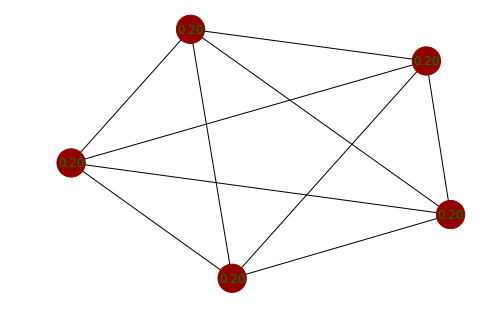

In [30]:
# Diffusion on the complete graph
def visualize_diffusion_on_barbell():
    G, layout = get_complete_graph(5)
    lap = nx.laplacian_matrix(G).toarray()
    starting_vertex = 0 # Vertex where diffusion starts
    def visualize_diffusion(beta=0.0):
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:0.2f}".format(kernel[starting_vertex, i]) for i in range(kernel.shape[0])}
        nx.draw(G, pos=layout, node_color=kernel[starting_vertex, :], labels=labels, node_size=800, cmap='hot',font_color='g', vmin=0, vmax=1.0)
        plt.show()

    interact(visualize_diffusion, beta=(0.0, 2.0))

visualize_diffusion_on_barbell()

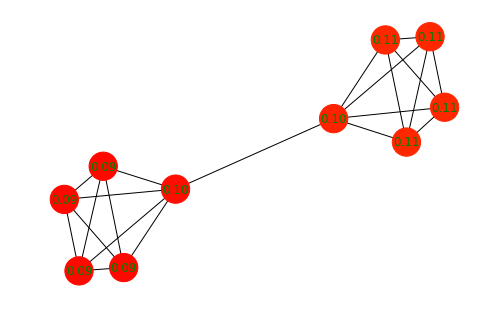

In [31]:
# Diffusion on barbell (dumbbell) graph
def visualize_diffusion_on_barbell():
    G, layout = get_barbell_graph(5)
    lap = nx.laplacian_matrix(G).toarray()
    starting_vertex = 0 # Vertex where diffusion starts
    def visualize_diffusion(beta=0.0):
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:0.2f}".format(kernel[starting_vertex, i]) for i in range(kernel.shape[0])}
        nx.draw(G, pos=layout, node_color=kernel[starting_vertex, :], labels=labels, node_size=800, cmap='hot',font_color='g', vmin=0, vmax=0.25)
        plt.show()

    interact(visualize_diffusion, beta=(0.0, 10.0))

visualize_diffusion_on_barbell()

# Relationship to Random Walks

Now we will consider how the diffusion kernel relates to Random Walks. In particular, let's consider a Lazy Random Walk (Note: This notion of a Lazy Random Walk is slightly different than the definition we have seen so far.)

#### Lazy Random Walk
Let $0 \leq \beta \leq \max_{i} 1/d_{i}$ be a parameter of the random walk (Looking forward, this will be the same parameter as $\beta$ in the diffusion kernel!). Given that you are at vertex $v_{i} \in V$ at time $t$, 
- Stay at $v_{i}$ with probability 1 - $\beta d_{i}$ (where $d_{i}$ is the degree of node $i$)
- Otherwise, sample an edge $(v_{i}, v) \in E$ uniformly and transition to $v$


Of course this means that we can write the random walk matrix as,
$$ W = (I - \beta D) + \beta A $$

The function below implements a single step of this Lazy Random Walk. For now, ignore the `num_steps` parameter.

In [32]:
def lazy_random_walk_step(p, G, beta, num_steps=1):
    '''
        Compute the probability distribution after num_steps of the RW defined above.
        :param p initial distribution
        :param G the graph
        :param beta paramter of the RW
        :param delta_t (time step - only matters in continuous setting)
        :param num_steps # of steps to take
        
    '''

    n = len(G.nodes())
    A = nx.adjacency_matrix(G).toarray()
    D = nx.laplacian_matrix(G).toarray() + A
    assert (beta <= 1/np.diag(D)).all() and beta >= 0
    # Lazy Random Walk Matrix
    beta = beta/num_steps
    W = (np.eye(n) - beta*D) + beta*A 
    return np.dot(np.linalg.matrix_power(W, num_steps), p)

def print_one_step_on_complete_graph():
    G, layout = get_complete_graph(5)
    # Initial distribution
    p_0 = np.zeros(len(G.nodes()), dtype=np.float32)
    p_0[0] = 1.0
    print('LAZY RANDOM WALK ON K_5')
    print('Initial Distribution (p_0)', p_0)
    p_1 = lazy_random_walk_step(p_0, G, 0.01)
    print('Distribution after one step with beta as 0.01 (p_1)', p_1)

    
print_one_step_on_complete_graph()

LAZY RANDOM WALK ON K_5
Initial Distribution (p_0) [1. 0. 0. 0. 0.]
Distribution after one step with beta as 0.01 (p_1) [0.96 0.01 0.01 0.01 0.01]


# Continuous Time

Now, let's relate this Lazy Random Walk to our Diffusion Kernel.

First, consider how we would write the transition matrix if we took $s$ steps of the random walk. We have previously seen that we can simply write our walk matrix to the $s$-th power. 
$$\left(I - \beta D + \beta A\right)^{s} $$


What happens if we take $s$ steps, but only transition from one edge to another with probability $\frac{\beta}{s}$? 
$$\left(I - \frac{\beta}{s} D + \frac{\beta}{s} A\right)^{s} $$


What if we take the limit as $s \rightarrow \infty$?
\begin{align}
\lim_{s \rightarrow \infty} \left(I - \frac{\beta}{s} D + \frac{\beta}{s} A\right)^{s}  
&= \lim_{s \rightarrow \infty} \left((I - \frac{\beta}{s} (D - A)\right)^{s}\\
&= \lim_{s \rightarrow \infty} \left(I - \frac{\beta}{s} L\right)^{s}\\
&= \exp(- \beta L)\\
\end{align}

Notice that we recover the diffusion kernel exactly.




In [4]:
def visualize_random_walk():
    G, layout = get_complete_graph(5)
    lap = nx.laplacian_matrix(G).toarray()
    def visualize(beta=0.0, steps=1):
        p = np.zeros(len(G.nodes()), dtype=np.float32)
        p[0] = 1.0
        delta_t = 1/steps
        p = lazy_random_walk_step(p, G, beta, steps)
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:.2f}".format(p[i]) for i in range(len(G.nodes()))}
        plt.subplot(121)
        plt.title('Lazy Random Walk')
        nx.draw(G, pos=layout, node_color=p, cmap='hot', labels=labels, font_color='r', node_size=600, vmin=0, vmax=1.0)
        plt.subplot(122)
        plt.title('Kernel')
        labels = {i: "{:.2f}".format(kernel[0, i]) for i in range(len(G.nodes()))}
        nx.draw(G, pos=layout, node_color=kernel[0, :], cmap='hot', labels=labels, node_size=600, font_color='r', vmin=0, vmax=1.0)
        plt.show()
    interact(visualize, steps=(1, 10000), beta=(0.0, 0.25, 0.001))

visualize_random_walk()

interactive(children=(FloatSlider(value=0.0, description='beta', max=0.25, step=0.001), IntSlider(value=1, des…

# Classification on Graphs

### Dataset

Imagine we have a graph $G = (V,E)$ and some labeled data for a subset of vertices $S = \left\{(v, l_v) \right\}_{v\in V'}$ where $l_v \in \{-1, 1\}$. We want to classify the nodes that are not in our dataset.

### Simple Classification Algorithm 
Here is a simple classification algorithm (Aside: we could improve this algorithm by using a more complicated technique like SVMs)
1. Given $G = (V,E)$ and $\beta$, compute the matrix $K_{\beta}$.
1. To classify a new node $u \in V$, compute the score $s(u)$, 
$$ s(u) = \sum_{(v, l_v) \in S} l_v * K(u, v)$$
1. If $s(u) > 0$, predict $1$ else predict $-1$

### Interpretation

Start a *diffusion* at each labeled node. If the node is labeled positively, start a diffusion with postive heat. If the node is labeled negatively, start the diffusion with "negative" heat. Choose $\beta$ to determine how long to run the diffusion. For all other nodes, predict +1 if the resulting heat at the node is positive, otherwise predict -1.


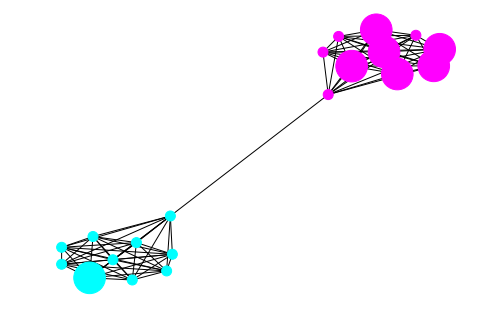

In [33]:
# Classification on dumbbell graph

def classification_on_dumbbell():
    n,p = 20, 0.2
    G, layout = get_barbell_graph(10)
    lap = nx.laplacian_matrix(G).toarray()
    labels = np.zeros(n)
    labels[[0,1, 2, 3, 4, 5]] = 1
    labels[[18]]= -1

    def compute_scores(K):
        return np.sum(np.expand_dims(labels, 1)*K[:, :], axis=0)

    def visualize_classification(beta):
        kernel = scipy.linalg.expm(-lap*beta)
        predictions = 2*(compute_scores(kernel) > 0) - 1

        # We know these values from the GT
        predictions = (labels != 0)*labels + (labels ==0)*predictions

        # Draw the Ground Truth larger than other nodes
        sizes = [1000 if labels[i] != 0 else 100 for i in range(n)]
        nx.draw(G, pos=layout, node_color=predictions, node_size=sizes, cmap='cool', vmin=-1.0, vmax=1.0)
        plt.show()

    interact(visualize_classification, beta=(0.001, 10, 0.001))

classification_on_dumbbell()

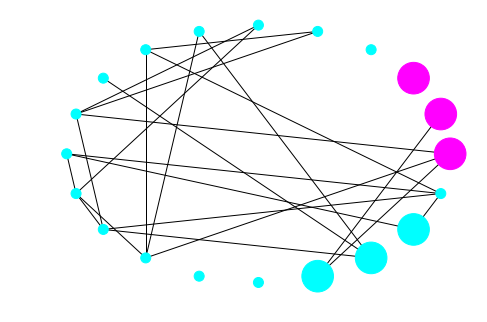

In [9]:
# Classification on random graph
def classification_on_random_graph():
    n,p = 20, 0.1
    G, layout = get_random_graph(n, p)
    lap = nx.laplacian_matrix(G).toarray()
    labels = np.zeros(n)
    labels[[0,1, 2]] = 1
    labels[[18, 17, 16]]= -1

    def compute_scores(K):
        return np.sum(np.expand_dims(labels, 1)*K[:, :], axis=0)

    def visualize_classification(beta):
        kernel = scipy.linalg.expm(-lap*beta)
        predictions = 2*(compute_scores(kernel) > 0) - 1

        # We know these values from the GT
        predictions = (labels != 0)*labels + (labels ==0)*predictions

        # Draw the Ground Truth larger than other nodes
        sizes = [1000 if labels[i] != 0 else 100 for i in range(n)]
        nx.draw(G, pos=layout, node_color=predictions, node_size=sizes, cmap='cool', vmin=-1.0, vmax=1.0)
        plt.show()

    interact(visualize_classification, beta=(0.001, 10, 0.001))

classification_on_random_graph()

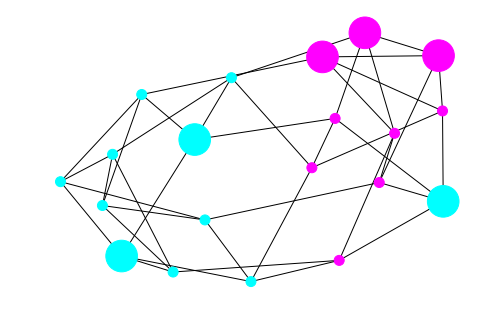

In [10]:
# Classification on random regular graph

def classification_on_random_regular_graph():
    n,d  = 20, 4
    G, layout = get_random_regular_graph(n, d)
    lap = nx.laplacian_matrix(G).toarray()
    labels = np.zeros(n)
    labels[[0,1, 2]] = 1
    labels[[18, 17, 16]]= -1

    def compute_scores(K):
        return np.sum(np.expand_dims(labels, 1)*K[:, :], axis=0)

    def visualize_classification(beta):
        kernel = scipy.linalg.expm(-lap*beta)
        predictions = 2*(compute_scores(kernel) > 0) - 1

        # We know these values from the GT
        predictions = (labels != 0)*labels + (labels ==0)*predictions

        # Draw the Ground Truth larger than other nodes
        sizes = [1000 if labels[i] != 0 else 100 for i in range(n)]
        nx.draw(G, pos=layout, node_color=predictions, node_size=sizes, cmap='cool', vmin=-1.0, vmax=1.0)
        plt.show()

    interact(visualize_classification, beta=(0.001, 10, 0.001))

classification_on_random_regular_graph()